In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Error and SNR

In [25]:
df = pd.read_csv('../src/results/demo1_main.tsv', sep='\t')

In [26]:
df2 = df.groupby('i').agg([np.mean, np.std])

In [27]:
print df2

     j              sigma          hit           hit_l1_err                \
  mean      std      mean  std    mean       std       mean           std   
i                                                                           
0  4.5  3.02765  0.001000  0.0  1023.9  0.316228   0.000008  1.843194e-07   
1  4.5  3.02765  0.003162  0.0  1024.0  0.000000   0.000023  7.908901e-07   
2  4.5  3.02765  0.010000  0.0  1024.0  0.000000   0.000074  3.372796e-06   
3  4.5  3.02765  0.031623  0.0  1024.0  0.000000   0.000230  7.998089e-06   
4  4.5  3.02765  0.100000  0.0  1024.0  0.000000   0.000742  2.053958e-05   
5  4.5  3.02765  0.316228  0.0  1024.0  0.000000   0.002304  8.036611e-05   
6  4.5  3.02765  1.000000  0.0  1024.0  0.000000   0.006849  1.999415e-04   

  hit_l2_err                  ...    miss_l1_err           miss_l2_err  \
        mean           std    ...           mean       std        mean   
i                             ...                                        
0   0.0

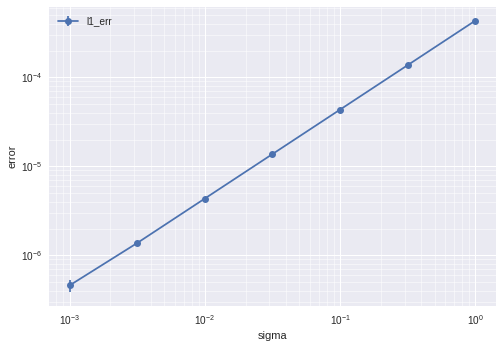

In [28]:
t1 = df2[[('sigma', 'mean'), ('l1_err', 'mean'), ('l1_err', 'std')]].values
t2 = df2[[('sigma', 'mean'), ('l2_err', 'mean'), ('l2_err', 'std')]].values

plt.figure()
plt.errorbar(t1[:,0], t1[:,1], yerr=t1[:,2], marker='o', label='l1_err')
#plt.errorbar(t2[:,0], t2[:,1], yerr=t2[:,2], marker='x', label='l2_err')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('sigma')
plt.ylabel('error')
plt.legend()
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.grid(b=True, which='minor', color='w', linewidth=0.5)
fig = plt.gcf()
fig.savefig('../report/graph/noise.eps')
fig.savefig('../report/graph/noise.png')
plt.show()

# Runtime plots

There are two plots. One is fix N, vary K. The other is fix K, vary N.

In [29]:
# Run Google benchmarks and dump to csv file. This has data for both plots.
df = pd.read_csv('../src/results/runtime.csv')
df = df[['name', 'cpu_time']]
print df.head()

                          name    cpu_time
0     BM_Demo1/4194301/64_mean  19196800.0
1   BM_Demo1/4194301/64_stddev    391143.0
2    BM_Demo1/4194301/128_mean  27718700.0
3  BM_Demo1/4194301/128_stddev    343425.0
4    BM_Demo1/4194301/256_mean  43247300.0


In [30]:
# Just processing MPSFT data first. This is used for both plots.
label = df['name'].values
list_n = []
list_k = []
list_typ = []
for s in label:
    toks = s.split('_')
    assert len(toks) == 3
    typ = toks[-1]
    toks = toks[1].split('/')
    assert len(toks) == 3
    n = int(toks[1])
    k = int(toks[2])
    list_n.append(n)
    list_k.append(k)
    list_typ.append(typ)
df['n'] = list_n
df['k'] = list_k
df['typ'] = list_typ
df = df[df['typ'] == 'mean'].copy()
df['time_sec'] = df['cpu_time'].astype(float) / 1.0e9
df.head()

,name,cpu_time,n,k,typ,time_sec
0,BM_Demo1/4194301/64_mean,19196800.0,4194301,64,mean,0.019197
2,BM_Demo1/4194301/128_mean,27718700.0,4194301,128,mean,0.027719
4,BM_Demo1/4194301/256_mean,43247300.0,4194301,256,mean,0.043247
6,BM_Demo1/4194301/512_mean,74886500.0,4194301,512,mean,0.074886
8,BM_Demo1/4194301/1024_mean,141392000.0,4194301,1024,mean,0.141392


## Fix N vary K

In [31]:
# Run SFFT (sfft_fork). The optimized version doesn't seem to work.
df1 = pd.read_csv('../../sfft_fork/results/vary_k_sfft1.tsv', header=None, sep='\t')
df2 = pd.read_csv('../../sfft_fork/results/vary_k_sfft2.tsv', header=None, sep='\t')
cols = ['label', 'n', 'k', 'snr', 'time_sec']
df1.columns = cols
df2.columns = cols
print df1.head()
print df2.head()

  label        n    k  snr  time_sec
0  sfft  4194304   50  100  0.014337
1  fftw  4194304   50  100  0.237978
2  sfft  4194304  100  100  0.021584
3  fftw  4194304  100  100  0.240291
4  sfft  4194304  200  100  0.035738
  label        n    k  snr  time_sec
0  sfft  4194304   50  100  0.007114
1  fftw  4194304   50  100  0.241489
2  sfft  4194304  100  100  0.008576
3  fftw  4194304  100  100  0.236669
4  sfft  4194304  200  100  0.014946


In [32]:
# Get FFTW running time for this fixed N.
f1 = df1[df1['label'] == 'fftw']['time_sec']
f2 = df2[df2['label'] == 'fftw']['time_sec']
fftw_time = np.concatenate((f1.values, f2.values)).mean()
df1 = df1[df1['label'] == 'sfft'].copy()
df2 = df2[df2['label'] == 'sfft'].copy()
print fftw_time
print df1.head()

0.240437739898
  label        n     k  snr  time_sec
0  sfft  4194304    50  100  0.014337
2  sfft  4194304   100  100  0.021584
4  sfft  4194304   200  100  0.035738
6  sfft  4194304   500  100  0.068100
8  sfft  4194304  1000  100  0.112369


Google Benchmarks measurements is 241538333 ns roughly.

In [33]:
# Take a subset of MPSFT data.
subdf = df[df['n'] == 4194301].copy()
subdf.sort_values(by='k', inplace=True)
print subdf

                          name     cpu_time        n     k   typ  time_sec
32    BM_Demo1/4194301/50_mean   18051200.0  4194301    50  mean  0.018051
0     BM_Demo1/4194301/64_mean   19196800.0  4194301    64  mean  0.019197
2    BM_Demo1/4194301/128_mean   27718700.0  4194301   128  mean  0.027719
4    BM_Demo1/4194301/256_mean   43247300.0  4194301   256  mean  0.043247
6    BM_Demo1/4194301/512_mean   74886500.0  4194301   512  mean  0.074886
8   BM_Demo1/4194301/1024_mean  141392000.0  4194301  1024  mean  0.141392
10  BM_Demo1/4194301/2048_mean  269261000.0  4194301  2048  mean  0.269261
12  BM_Demo1/4194301/4096_mean  521286000.0  4194301  4096  mean  0.521286


No point storing the stddev. We know they are very small relative to the mean.

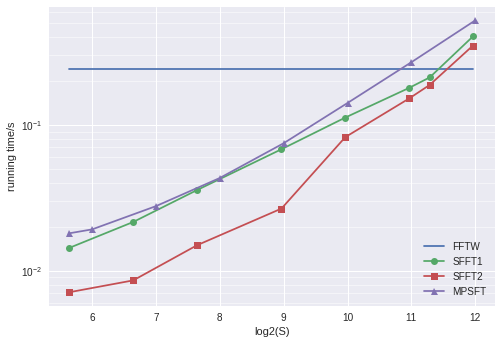

In [34]:
plt.figure()
plt.clf()
kk = np.log2(np.array(df1['k'].values))
plt.plot(kk, fftw_time * np.ones(kk.shape), label='FFTW')
plt.plot(kk, df1['time_sec'].values, label='SFFT1', marker='o')
plt.plot(kk, df2['time_sec'].values, label='SFFT2', marker='s')
plt.plot(np.log2(subdf['k'].values), subdf['time_sec'].values, label='MPSFT', marker='^')
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('log2(S)')
plt.ylabel('running time/s')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.grid(b=True, which='minor', color='w', linewidth=0.5)
plt.legend()
fig = plt.gcf()
fig.savefig('../report/graph/runtime_vary_k.eps')
fig.savefig('../report/graph/runtime_vary_k.png')
plt.show()

## Fix K, vary N
This is where we see MPSFT shine relative to SFFT1 and SFFT2.

In [35]:
df1 = pd.read_csv('../../sfft_fork/results/vary_n_sfft1.tsv', header=None, sep='\t')
df2 = pd.read_csv('../../sfft_fork/results/vary_n_sfft2.tsv', header=None, sep='\t')
cols = ['label', 'n', 'k', 'snr', 'time_sec']
df1.columns = cols
df2.columns = cols
print df1.head()
print df2.head()

  label      n   k  snr  time_sec
0  sfft   8192  50  100  0.001403
1  fftw   8192  50  100  0.000122
2  sfft  16384  50  100  0.001908
3  fftw  16384  50  100  0.000265
4  sfft  32768  50  100  0.001583
  label      n   k  snr  time_sec
0  sfft   8192  50  100  0.001484
1  fftw   8192  50  100  0.000122
2  sfft  16384  50  100  0.002111
3  fftw  16384  50  100  0.000272
4  sfft  32768  50  100  0.001750


In [36]:
# Grab FFTW time.
tmp1 = df1[df1['label'] == 'fftw'].copy()
tmp2 = df2[df2['label'] == 'fftw'].copy()
assert tmp1.shape == tmp2.shape
assert np.max(np.abs(tmp1['n'] - tmp2['n'])) == 0
assert np.max(np.abs(tmp1['k'] - tmp2['k'])) == 0
fftw_n = tmp1['n'].values
fftw_time = 0.5 * (tmp1['time_sec'] + tmp2['time_sec'])

In [37]:
# Now grab SFFT1 and SFF2 time.
df1 = df1[df1['label'] == 'sfft'].copy()
df2 = df2[df2['label'] == 'sfft'].copy()
print df1.head()

  label       n   k  snr  time_sec
0  sfft    8192  50  100  0.001403
2  sfft   16384  50  100  0.001908
4  sfft   32768  50  100  0.001583
6  sfft   65536  50  100  0.002227
8  sfft  131072  50  100  0.002424


In [38]:
# Take a subset of MPSFT data.
subdf = df[df['k'] == 50].copy()
subdf.sort_values(by='n', inplace=True)
print subdf

                         name    cpu_time         n   k   typ  time_sec
14      BM_Demo1/8191/50_mean   7791760.0      8191  50  mean  0.007792
16     BM_Demo1/16381/50_mean   8540950.0     16381  50  mean  0.008541
18     BM_Demo1/32771/50_mean   9184060.0     32771  50  mean  0.009184
20     BM_Demo1/65537/50_mean   9911220.0     65537  50  mean  0.009911
22    BM_Demo1/131071/50_mean  10770100.0    131071  50  mean  0.010770
24    BM_Demo1/262147/50_mean  11984400.0    262147  50  mean  0.011984
26    BM_Demo1/524287/50_mean  13715600.0    524287  50  mean  0.013716
28   BM_Demo1/1048573/50_mean  15445400.0   1048573  50  mean  0.015445
30   BM_Demo1/2097143/50_mean  16843100.0   2097143  50  mean  0.016843
32   BM_Demo1/4194301/50_mean  18051200.0   4194301  50  mean  0.018051
34   BM_Demo1/8388617/50_mean  18673200.0   8388617  50  mean  0.018673
36  BM_Demo1/16777213/50_mean  20034100.0  16777213  50  mean  0.020034
38  BM_Demo1/33554467/50_mean  21076200.0  33554467  50  mean  0

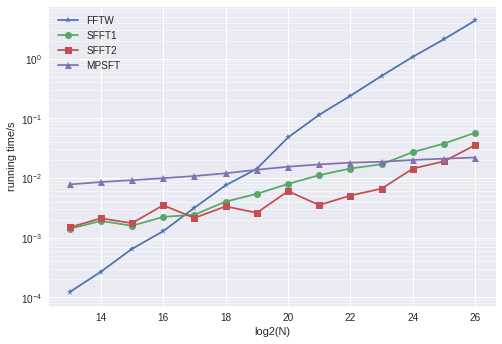

In [39]:
plt.figure()
plt.clf()
plt.plot(np.log2(fftw_n), fftw_time, label='FFTW', marker='*')
plt.plot(np.log2(df1['n'].values), df1['time_sec'].values, label='SFFT1', marker='o')
plt.plot(np.log2(df2['n'].values), df2['time_sec'].values, label='SFFT2', marker='s')
plt.plot(np.log2(subdf['n'].values), subdf['time_sec'].values, label='MPSFT', marker='^')
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('log2(N)')
plt.ylabel('running time/s')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.grid(b=True, which='minor', color='w', linewidth=0.5)
plt.legend()
fig = plt.gcf()
fig.savefig('../report/graph/runtime_vary_n.eps')
fig.savefig('../report/graph/runtime_vary_n.png')
plt.show()